In [1]:
!pip install torchvision
!pip install matplotlib

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


Establecemos la configuración de nuestro CVAE. Recordamos que el batch size es el numero de imágenes procesadas juntas.

In [3]:

# Configuración
batch_size = 128
latent_dim = 16  # Dimensión del espacio latente
num_classes = 10  # Dígitos del 0 al 9

Descargamos los datos de entrenamiento (train=True) y prueba (train=False) del dataset MNIST, y transformamos las imagenes de los números a tensores. Los tensores tendrán 3 dimensiones: canal (1 por ser una imagen en escala de grises), alto (28) y ancho (28).  

In [4]:

# Cargar MNIST con transformación a tensores
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = torchvision.datasets.MNIST(
    root='./data', 
    train=True, 
    transform=transform,
    download=True
)
test_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    transform=transform,
    download=True
)

Pasamos los datos de entrenamiento y test a una estructura DataLoader, pasando como parametro el batch size para procesar el dataset por lotes. De esa manera los tensores pasan de 3 a 4 dimensiones (B, C, H, W).

In [5]:

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False
)


&nbsp;
&nbsp;
#### Encoder de CVAE

El objetivo del encoder es transformar una imagen (28x28) y su etiqueta (10) en un espacio latente de dimension "laten_dim" (16 en este caso). En el espacio latente cada dato de entrada (imagen + etiqueta) está representado (mapeado) con una distribución probabilística, compuesto de la media y la varianza del dato de entrada.

**Método init()**:

En la función init() definimos los elementos que formarán parte del encoder. Como se puede ver, esos elementos son:
* fc1: una capa lineal de 794 neuronas de entrada y 400 neuronas de salida. La razón de las 794 neuronas es que necesitamos introducir en ellas las imágenes y su etiqueta correspondiente, ambas en forma de tensor. El número 794 es el resultado de sumar 28*28 (768 = número de pixels de la imagen aplanada) y 10 (número de clases, del 0 al 9). El número de salidas de esa primrea capa lineal, 400, es porque la entrada del las capas fc2_mean y fc2_logvar es 400 también.

* fc2_mean: capa que calcula la **media** (centro) de cada uno de los datos de entrada (imagen + etiqueta).

* fc2_logvar: capa que calcula la **varianza** (centro) de cada uno de los datos de entrada (imagen + etiqueta).

**Método forward()**:

En un modelo CVAE, la entrada de cada uno de los datos tiene que llevar asociada su etiqueta correspondiente. Es decir al introducir en el modelo la imagen de un número 5, tendremos que añadir su etiqueta 5. La etiqueta será un tensor pyTorch, que se introduce en el encoder junto con la imagen. Por ejemplo, la etiqueta del número 5 es un tensor de 10 valores tal que [0, 0, 0, 0, 0, 1, 0, 0, 0, 0].

Recordemos que en una celda previa, las imágenes las hemos convertido a tensores pyTorch, de la misma manera actuaremos con las etiquetas, es decir las convertiremos a tensores. De esta manera, al ser las dos elementos tensores, podremos concatenarlos para pasarlos a fc1 juntos. Dicha operación la realizamos a través de la función de pyTorch "torch.cat()". Para la concatenación, es necesario que ambos elementos tengan el mismo número de dimensiones, si no, dara error. Así que será necesario aplanar la imagen para que pasé de de 3 a 2 dimensiones al igual que la etiqueta.

Al final del método calculamos la media y la varianza del vector y los devolvemos.


In [6]:
class Encoder(nn.Module):
    def __init__(self, z_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(28*28 + num_classes, 400) # images are 28x28

        print(num_classes)

        self.fc2_mean = nn.Linear(400, z_dim)
        self.fc2_logvar = nn.Linear(400, z_dim)
        self.relu = nn.ReLU()

    def forward(self, x, label):
        # Flatten the 28x28 images so the concatenation in the next line works correctly. Otherwise, 
        # the concatenation would not work as x (image converted to PyTorch tensor) has dimension
        # [batch, 28, 28] and label (classes converted to PyTorch tensor) has dimension
        # [batch, 10].
        x = x.view(-1, 28*28)  

        x_label = torch.cat([x, label], dim=-1) # concatenamos la imagen y su etiqueta y el resultado lo asignmos a la variable "x_label" ("x" por la imagen y "label" por la etiqueta).
        
        x_label_relu = self.relu(self.fc1(x_label))

        z_mean = self.fc2_mean(x_label_relu)
        z_logvar = self.fc2_logvar(x_label_relu)
        
        return z_mean, z_logvar

#### Decoder de CVAE

Esto es el código del decoder CVAE, que recibe como entrada un vector proveniente del espacio latente "z" (dimensión 16 en este caso) y una etiqueta de clase (número a partir del cual queremos que se genere una imagen), y genera una imagen reconstruida.

**Método init()**

* fc1 (convierte vectores de 26 dimensiones a vectores de 400 dimensiones): 
    * entrada:  26 neuronas, para poder recibir vectores de 26 elementos, ya que concatenamos vectores del espacio latente (16) y vectores que representan el número del que se quieren generar imágenes.
    * salida: 400 neuronas. Se elige 400 porque suele ser el valor que mejores resultados da. 

* fc2 (convierte vectores de 400 dimensiones a vectores de 784 dimensiones): 
    * entrada: 400 neuronas
    * salida: 784 neuronas ya que las imagenes que queremos generar son de 28x28.
    
* sigmoid: convierte vectores de 784 elementos a imágenes de tamaño 28x28.

**Método forward()**

* 1. Concatenamos el vector que viene del espacio latente con el vector asociado a la etiqueta del número que queremos generar una imagen.
* 2. Lo introducimos en fc1.
* 3. Lo pasamos por la capa de activación relu.
* 4. Lo introducimos en fc2.
* 5. Lo pasamos por la capa sigmoide para generar la imagen.

In [7]:
class Decoder(nn.Module):
    
    def __init__(self, z_dim):
    
        super(Decoder, self).__init__()
    
        self.fc1 = nn.Linear(z_dim + num_classes, 400)  # z_dim + num_classes (para la etiqueta)
        
        self.relu = nn.ReLU()
        
        self.fc2 = nn.Linear(400, 28*28)
        
        self.sigmoid = nn.Sigmoid()

    def forward(self, z, label):

        z_label = torch.cat([z, label], dim=-1)  # Concatenamos z con la etiqueta
        
        x = self.fc1(z_label)
        
        # Le he metido entre las capas lineales una Relu porque Pablo me ha dicho que las capas lineales
        # sin "nada" entre medias es como si no hiciesemos "nada". Es decir, da lo mismo si pones 1 o 100 capas
        # lineales si no pones "nada" entre medias.
        x = self.relu(x) 
        x = self.fc2(x)
        return self.sigmoid(x).view(-1, 28, 28)  # Reconstrucción de la imagen

### CVAE

Aquí implementamos el modelo generativo condicional.

**Método init()**

1. Creamos una instancia del encoder.
2. Creamos una instancia del decoder.

**Método reparameterize()**

Este método se llama entre el encoder y el decoder, es decir, toma las salidas del encoder (media y varianza) y devuelve un vector del espacio latente que se pasa al decoder.

En su interior se realiza el llamado "reparameterization trick".

**Método forward()**

1. Llamamo al encoder pasandole la imagen y su correspondiente etiqueta.
2. Llamamo al reparameterize() para hacer el "reparameterization trick".

In [8]:
class CVAE(nn.Module):

    def __init__(self, z_dim):

        super(CVAE, self).__init__()

        self.encoder = Encoder(z_dim)

        self.decoder = Decoder(z_dim)


    def reparameterize(self, mean, logvar):

        std = torch.exp(0.5 * logvar)

        eps = torch.randn_like(std)

        return mean + eps * std


    def forward(self, x, label):

        z_mean, z_logvar = self.encoder(x, label)
 
        z = self.reparameterize(z_mean, z_logvar)
 
        reconstructed_x = self.decoder(z, label)
 
        return reconstructed_x, z_mean, z_logvar

**Función de perdida**

* BCE (binary cross-entropy): recibe como parametros la imagen real y la reconstruida para medir cuanto se diferencian. Se suele usar para imágenes binarias (blanco/negro) como es nuestro caso, además de en problemas de clasificación binaria, de ahí lo del nombre (BINARY cros-entropy).

* KL (divergencia Kullback-Leibler): mide como de diferentes son dos probabilidades de distribución. En CVAEs permite asegurar que el espacio latente sigue una distribución normal, ayudando al model a generar salidas con sentido. 

In [9]:

def loss_function(reconstructed_x, x, z_mean, z_logvar):

    BCE = nn.BCELoss(reduction='sum')   (reconstructed_x.view(-1, 28*28)   ,    x.view(-1, 28*28))

    # Cálculo de la divergencia KL
    KL = -0.5 * torch.sum(1 + z_logvar - z_mean.pow(2) - z_logvar.exp())

    return BCE + KL

Usaremos la GPU para realizar el entrenamiento del modelo.

Instanciamos el model y se los pasamos a la GPU.

Usamos Adam como optimizador para el entrenamiento.

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CVAE(z_dim=latent_dim).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

10


**Entrenamiento del modelo**

Vamos a entrenar el modelo durante 50 epochs.

En cada epoch calcularemos la funcion de perdida y la mostramos.

In [11]:
epochs = 5
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        target_one_hot = torch.zeros(target.size(0), num_classes).to(device).scatter_(1, target.view(-1, 1), 1)
        
        optimizer.zero_grad()
        reconstructed_data, z_mean, z_logvar = model(data, target_one_hot)
        loss = loss_function(reconstructed_data, data, z_mean, z_logvar)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss/len(train_loader.dataset)}")


Epoch 1/5, Loss: 162.58331987304686
Epoch 2/5, Loss: 119.65887294921875
Epoch 3/5, Loss: 112.91282361653646
Epoch 4/5, Loss: 109.59543572591146
Epoch 5/5, Loss: 107.50340895182292


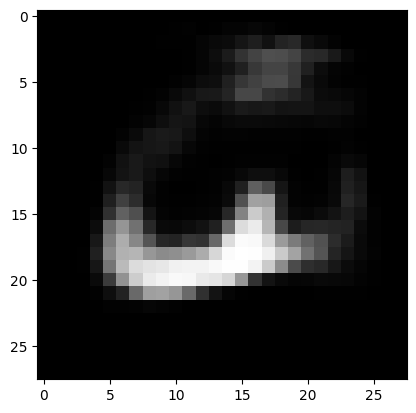

In [12]:
model.eval()
with torch.no_grad():
    labels = torch.tensor(6).to(device)  # Queremos generar el dígito "8"
    labels_one_hot = torch.zeros(1, num_classes).to(device).scatter_(1, labels.view(-1, 1), 1)
    z = torch.randn(1, latent_dim).to(device)  # Z aleatorio
    generated_image = model.decoder(z, labels_one_hot)

    plt.imshow(generated_image.cpu().squeeze().numpy(), cmap='gray')
    plt.show()

In [13]:
#torch.save(model.state_dict(), "cvae_model.pth")

In [21]:
import torch
import os

artifact_dir = "./artifacts"
os.makedirs(artifact_dir, exist_ok=True)

# Guardar solo los pesos (recomendado para producción)
torch.save(model.state_dict(), os.path.join(artifact_dir, "cvae_model_state_dict.pth"))

# Opcional: guardar los hiperparámetros o configuración
config = {
    "latent_dim": latent_dim,
    "num_classes": num_classes,
    "batch_size": batch_size,
    "epochs": epochs
}
import json
with open(os.path.join(artifact_dir, "config.json"), "w") as f:
    json.dump(config, f)